## Visualizing Global Progress in reducing Infant Mortality Rates (1985 - 2022) ##

This dataset is from the WHO Health Inequality Data Repository.

This dataset contains data on indicators from the World Health Organization's (WHO) Global Health Observatory (GHO), disaggregated by age, economic status, place of residence and sex. The GHO is WHO's data repository for health-related statistics for its 194 Member States, providing access to over 1000 indicators on priority health topics.

**Import Dependencies**

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff

**Load Data**

In [2]:
# Load data
df = pd.read_excel(r"C:\Users\User\Python Projects\WHO Data\Reproductive Data\rep_gho_rmnch\data.xlsx")

#Preview data
#df.head()

**Data Cleaning**

In [3]:
# Trimming leading and trailing spaces
df = df.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)

# Deleting columns 'se', 'population', and 'flag' for having 0 non-nulls
df = df.drop(columns = ['se', 'population', 'flag'], axis = 1)

# Check for data completeness wrt number of countries covered in each year
countries_covered = df.groupby('date')['setting'].nunique().reset_index()
countries_covered.columns = ['year', 'num_countries']

# Visualising number of countries covered in each year
#px.bar(countries_covered,
       #x = 'year',
       #y = 'num_countries',
      #template = 'simple_white',
      #title = 'Check for completeness of data',
       #labels = dict(num_countries = 'Number of countries surveyed'),
       #height = 500)

# From 1985 onwards, the survey consistently covered 195 to 198 countries each year
incomplete_survey_years = countries_covered[countries_covered['num_countries'] < 195]['year'].tolist()

# Removing the incomplete survey years from the mortatility data frame
df = df[~df['date'].isin(incomplete_survey_years)]

# Replacing null values in the World Bank Income and WHO Region columns
df['wbincome2024'] = df['wbincome2024'].fillna("Income Categorization Missing")
df['whoreg6'] = df['whoreg6'].fillna("Region Categorization Missing")

**Data Transformation**

In [4]:
# Creating df for Infant Mortality Rate (IMR) data
imr_df = df[df['indicator_name'] == 'Infant mortality rate (deaths per 1000 live births)']

imr_df = imr_df.pivot_table(
    index = ['setting', 'date', 'indicator_abbr', 'indicator_name', 'dimension', 'setting_average',
             'iso3', 'favourable_indicator', 'indicator_scale', 'whoreg6', 'wbincome2024'],
    columns = 'subgroup',
    values = ['estimate', 'ci_lb', 'ci_ub'])

imr_df.columns = ['_'.join(col).strip() for col in imr_df.columns.values]
imr_df = imr_df.reset_index()

# Renaming columns
imr_columns = {
    'setting_average': 'imr_average',
    'favourable_indicator': 'imr_favourable_indicator',
    'indicator_scale': 'imr_indicator_scale',
    'ci_lb_Female': 'imr_ci_lb_female',
    'ci_lb_Male': 'imr_ci_lb_male',
    'ci_ub_Female': 'imr_ci_ub_female',
    'ci_ub_Male': 'imr_ci_ub_male',
    'estimate_Female': 'imr_estimate_female',
    'estimate_Male': 'imr_estimate_male',
    'setting': 'country',
    'date': 'year',
    'whoreg6': 'who_region',
    'wbincome2024' : 'income_group'
}

imr_df = imr_df.rename(columns = imr_columns)
imr_df = imr_df.drop(columns = ['indicator_name', 'indicator_abbr', 'dimension'], axis = 1)

**Interactive Snapshot of Global Infant Mortality Rate**
<br>
<br>
Scroll through the years at the bottom of the graph

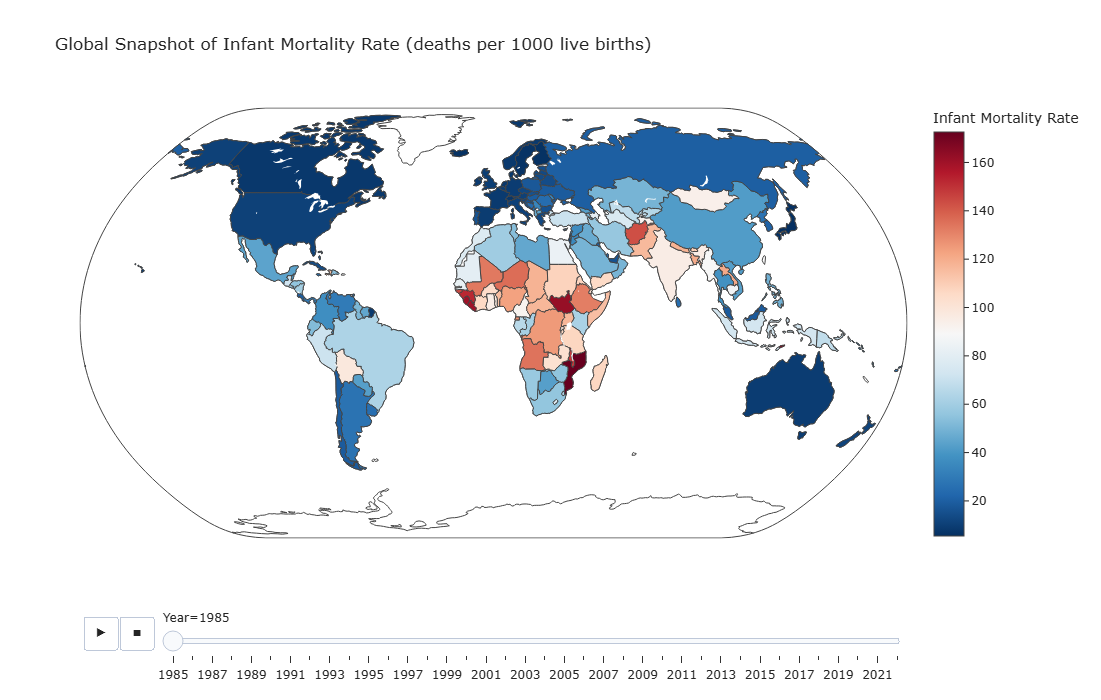

In [5]:
# Plotting Global Snapshot of IMR
px.choropleth(imr_df,
             locations = "iso3",  
             hover_name = "country",
             color = "imr_average",
             animation_frame = 'year',
             animation_group = 'country',
             projection = "natural earth",
              template = 'simple_white',
              title = 'Global Snapshot of Infant Mortality Rate (deaths per 1000 live births)',
              labels = dict(year = 'Year', country = 'Country', imr_average = 'Infant Mortality Rate'),
              color_continuous_scale = 'RdBu_r',
            height = 700)

**A National Comparison of Infant Mortality Rates With Countries of Similar Income Groups and Regions**
<br>
<br>
Click on 'Region' and 'Income Groups' to expand

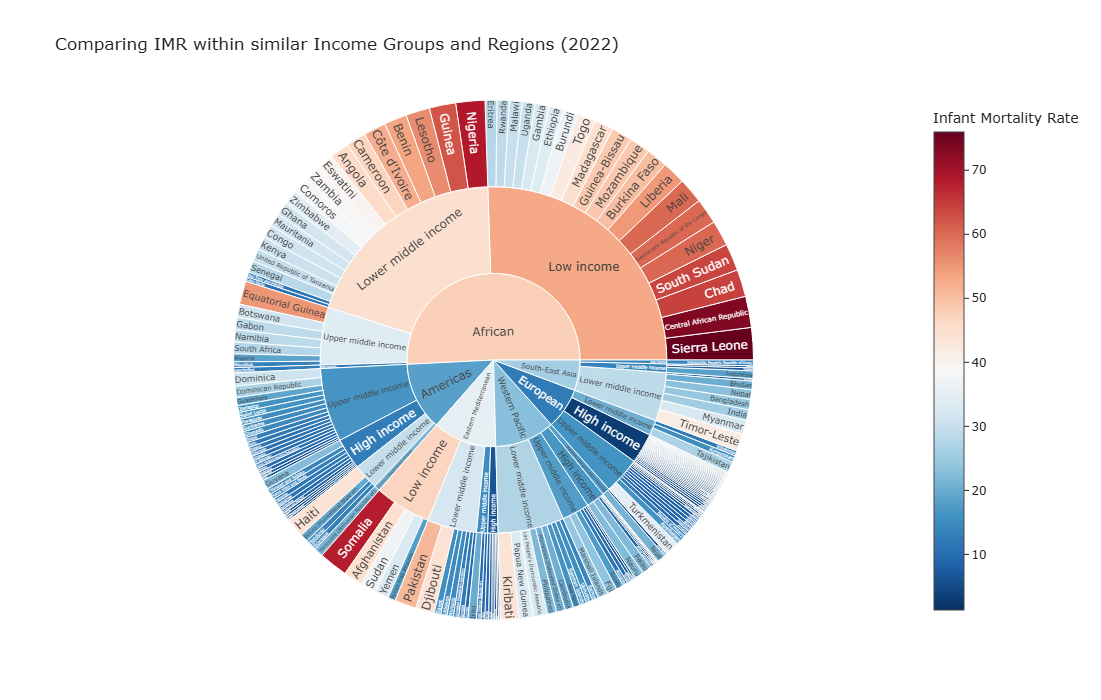

In [6]:
# Plotting sunburst
px.sunburst(imr_df.query("year == 2022"),
             path = ['who_region', 'income_group', 'country'],
             values = "imr_average",  
             hover_name = 'country',
             color = "imr_average",
            template = 'simple_white',
            title = 'Comparing IMR within similar Income Groups and Regions (2022)',
            labels = dict(year = 'Year', country = 'Country', imr_average = 'Infant Mortality Rate'),
            color_continuous_scale = 'RdBu_r',
            height = 700)

**Region wise trends in Infant Mortality Rates from 1985 to 2022**
<br>
<br>
Double click on 'Country' name to highlight trend

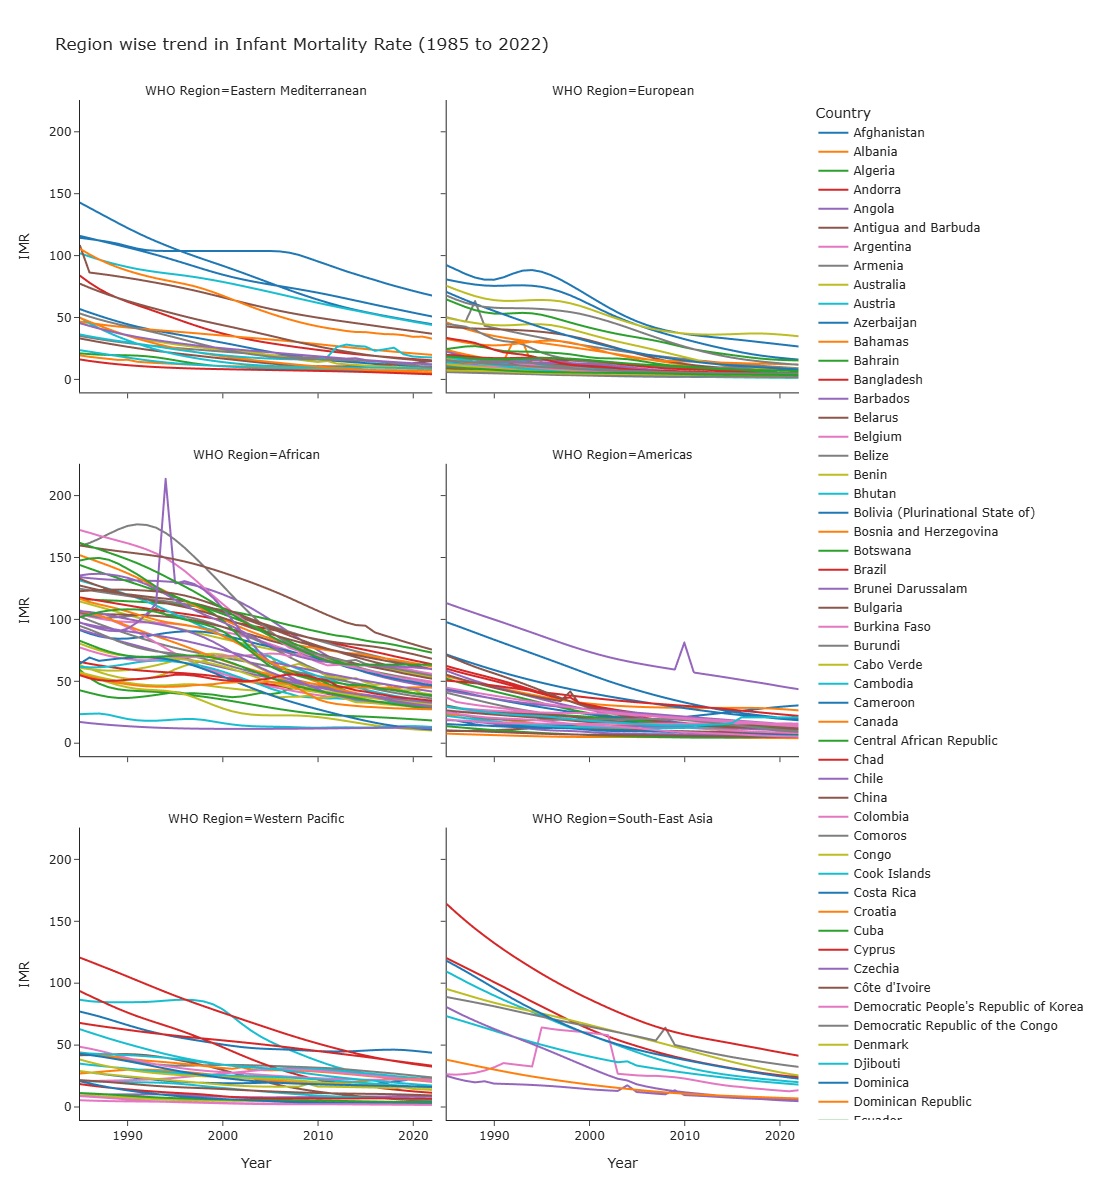

In [10]:
# Plotting Region wise trends in Infant Mortality Rate from 1985 to 2022
px.line(imr_df,
       x = 'year',
       y = 'imr_average',
       color = 'country',
        hover_name = 'country',
       facet_col = 'who_region',
       facet_col_wrap = 2,
       template = 'simple_white',
        title = 'Region wise trend in Infant Mortality Rate (1985 to 2022)',
        labels = dict(year = 'Year', imr_average = 'IMR', who_region = 'WHO Region', country = 'Country'),
       height = 1200)

**Distribution of Gender Gap in Infant Mortality Rate (2022)**
<br>
<br>
Scroll through the years at the bottom of the graph

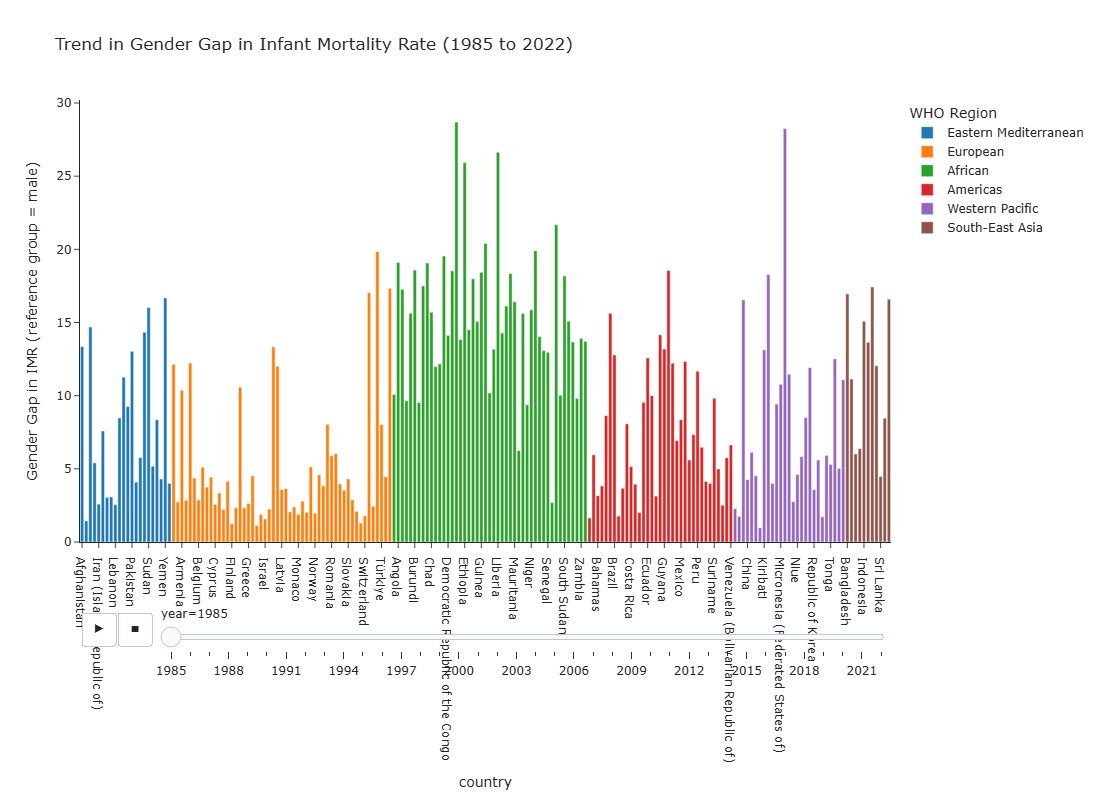

In [11]:
#Plotting distribution in gender gap
imr_df['imr_gender_gap'] = imr_df['imr_estimate_male'] - imr_df['imr_estimate_female']

px.bar(imr_df,
       y = 'imr_gender_gap',
       x = 'country',
       color = 'who_region',
       animation_frame = 'year',
       animation_group = 'country',
       height = 800,
       title = 'Trend in Gender Gap in Infant Mortality Rate (1985 to 2022)',
       labels = dict(who_region = 'WHO Region', imr_gender_gap = 'Gender Gap in IMR (reference group = male)'),
      template = 'simple_white')


**Region wise variance in IMR Gender Gap (2022)**

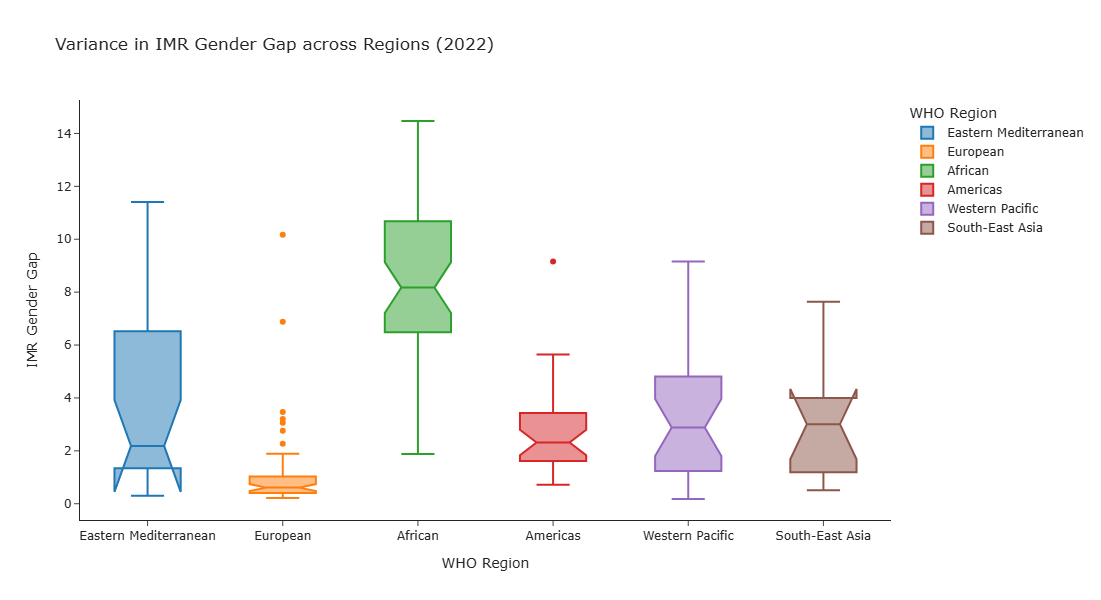

In [12]:
#Plotting region wise variance in IMR Gender Gap
px.box(imr_df.query("year == 2022"),
      x = 'who_region',
      y = 'imr_gender_gap',
      color = 'who_region',
      template = 'simple_white',
      height = 600,
      title = 'Variance in IMR Gender Gap across Regions (2022)',
       notched = True,
      labels = dict(who_region = 'WHO Region', imr_gender_gap = 'IMR Gender Gap'))